<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook I apply all the classification algorithms learned in Machine Learning with Python course from Coursera.

I load a dataset using Pandas library, clean and prepare the data, apply multiple algorithms, evaluate the accuracy of each algorithm and find the best one for this specific dataset.

First install and import the required libraries:

In [45]:
# The following libraries need to be installed once
#!conda install -c anaconda seaborn -yimport itertools
#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y
import numpy as np
import pandas as pd
import seaborn as sns
import pydotplus
import itertools
import pylab as pl
import scipy.optimize as opt

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import log_loss
from sklearn.externals.six import StringIO

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import matplotlib.image as mpimg
%matplotlib inline

### About dataset

The dataset contains records of past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted (i.e. "In collection"). It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Principal loan amount                                                                 |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effect                                          |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Download the dataset

In [46]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-02-27 16:10:02--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-02-27 16:10:02 (14.2 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [47]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [48]:
df.shape

(346, 10)

### Convert the effective_date and due_date columns to date time object format

In [49]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Count the number of each class of loan status in the data set 

In [50]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

### Visualize loan data by loan status, principal and gender


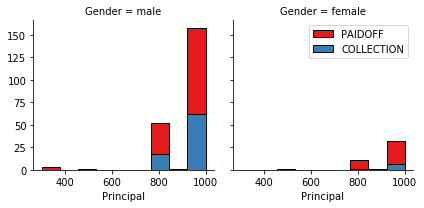

In [51]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

### Visualize loan data by age, principal and gender

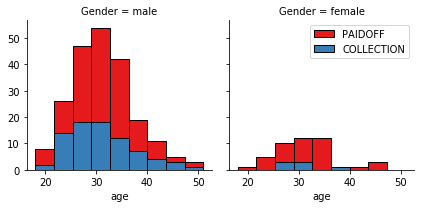

In [52]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Examine the day of the week people get the loan 

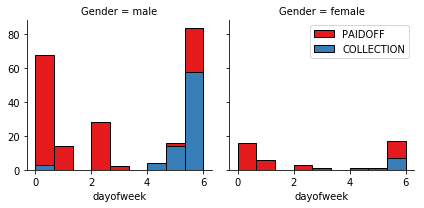

In [53]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


People who get the loan at the end of the week are much more likely to default on the loan, so use Feature binarization to set a threshold value of less then day 4 and save it in a column called "weekend"

In [54]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Examine gender:

In [55]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay their loans and 73 % of males pay there loan


Convert male to 0 and female to 1:


In [56]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


Examine education

In [57]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use One Hot Encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame 

In [60]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)

# Correct the spelling of Bachelor!
Feature.columns = Feature.columns.str.replace('Bechalor','Bachelor')

# Note that it is unclear why there are "college" and "Bachelor" columns. I'm assuming "college" means some college but
# not a Bachelor's degree, so I left them as separate columns

# Throw out "Master or above"
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bachelor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Define feature sets, X:

In [62]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bachelor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


Our dependant variable is loan_status and the labels are PAIDOFF and COLLECTION. Put them in "y"

In [63]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization - give data a mean of zero and unit variance

In [64]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

# Classification 

Now we use the training to build the models and the test set to report the accuracy of eack model
The following algorithms are compared:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression

## Split the data into train and test sets
These will be reused numerous times for testing the various classification algorithms with different hyperparameters

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


# K Nearest Neighbor(KNN)
Build KNN models with a range of k values and find the best k that results in a model with the best accuracy.  
Split the train_loan.csv into train and test to find the best k.

In [66]:
Ks = 25
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for k in range(1, Ks):
    #Train Model and Predict  
    knn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    yhat = knn.predict(X_test)
    mean_acc[k-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[k-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([ 0.67,  0.66,  0.71,  0.69,  0.76,  0.71,  0.79,  0.76,  0.76,
        0.67,  0.7 ,  0.73,  0.7 ,  0.7 ,  0.69,  0.73,  0.73,  0.73,
        0.7 ,  0.69,  0.71,  0.69,  0.7 ,  0.7 ])

## Plot the accuracy of KNN for all K between 1 and 25

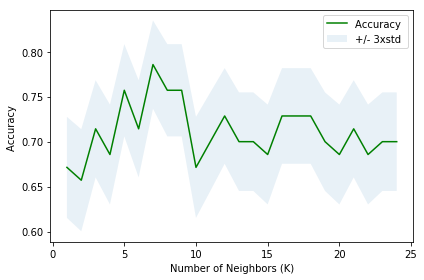

In [67]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [24]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.785714285714 with k= 7


# Decision Tree

Create an instance of the DecisionTreeClassifier called dTree.
Specify criterion="entropy" so we can see the information gain of each node. 

In [25]:
dTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

Fit the data with the training feature matrix X_trainset and training response vector y_trainset 

In [26]:
dTree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# Prediction
Make predictions on the testing dataset and store it into a variable called predTree. 

In [27]:
predTree = dTree.predict(X_test)

Visually compare the predictions with the test set

In [28]:
print (predTree [0:10])
print (y_test [0:10])

['COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


## Evaluation
Calculate the accuracy of the decision tree model against the ground truth

In [29]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.614285714286


## Visualization of the decision tree

In [30]:
dot_data = StringIO()
filename = "dtree.png"
featureNames = df.columns[0:8]
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(dTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(300, 300))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine

The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

1.Linear
2.Polynomial
3.Radial basis function (RBF)
4.Sigmoid

Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset, we usually choose different functions in turn and compare the results.

__The following code loops through all 4 kernel functions and evaluates the performance of each one to assess which is best.__

In [31]:
#JGV - loop through the 4 kernel functions
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

After being fitted, use the model to predict new values on the test set:

In [32]:
yhat = clf.predict(X_test)
yhat [0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

             precision    recall  f1-score   support

 COLLECTION       0.36      0.27      0.31        15
    PAIDOFF       0.81      0.87      0.84        55

avg / total       0.72      0.74      0.73        70

Confusion matrix, without normalization
[[ 4 11]
 [ 7 48]]


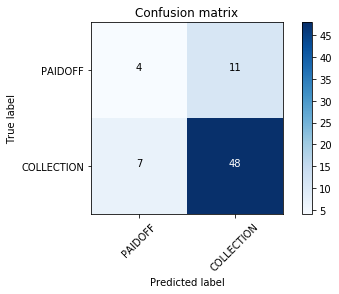

In [34]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

print(classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [35]:
print('F1 score = ', f1_score(y_test, yhat, average='weighted'))
print('Jaccard similarity = ', jaccard_similarity_score(y_test, yhat))

F1 score =  0.727588201272
Jaccard similarity =  0.742857142857


# Logistic Regression

Build the model using LogisticRegression from Scikit-learn package. This function implements logistic regression and can use different numerical optimizers to find parameters, including ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’ solvers. You can find extensive information about the pros and cons of these optimizers if you search it in internet.

Fit our model with train set:

In [36]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

Make predictions on the test set

In [37]:
yhat = LR.predict(X_test)

__predict_proba__ returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 1, P(Y=1|X), and second column is probability of class 0, P(Y=0|X):

In [38]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[ 0.5 ,  0.5 ],
       [ 0.45,  0.55],
       [ 0.31,  0.69],
       [ 0.34,  0.66],
       [ 0.32,  0.68],
       [ 0.32,  0.68],
       [ 0.49,  0.51],
       [ 0.48,  0.52],
       [ 0.34,  0.66],
       [ 0.49,  0.51],
       [ 0.34,  0.66],
       [ 0.5 ,  0.5 ],
       [ 0.25,  0.75],
       [ 0.34,  0.66],
       [ 0.44,  0.56],
       [ 0.26,  0.74],
       [ 0.52,  0.48],
       [ 0.3 ,  0.7 ],
       [ 0.5 ,  0.5 ],
       [ 0.32,  0.68],
       [ 0.44,  0.56],
       [ 0.49,  0.51],
       [ 0.51,  0.49],
       [ 0.47,  0.53],
       [ 0.41,  0.59],
       [ 0.51,  0.49],
       [ 0.51,  0.49],
       [ 0.37,  0.63],
       [ 0.5 ,  0.5 ],
       [ 0.25,  0.75],
       [ 0.47,  0.53],
       [ 0.46,  0.54],
       [ 0.46,  0.54],
       [ 0.48,  0.52],
       [ 0.39,  0.61],
       [ 0.46,  0.54],
       [ 0.5 ,  0.5 ],
       [ 0.29,  0.71],
       [ 0.46,  0.54],
       [ 0.45,  0.55],
       [ 0.51,  0.49],
       [ 0.32,  0.68],
       [ 0.45,  0.55],
       [ 0.

### Evaluation
__Jaccard index__
Try jaccard index for accuracy evaluation. Jaccard is the size of the intersection divided by the size of the union of two label sets.

In [39]:
print('Jaccard similarity = ', jaccard_similarity_score(y_test, yhat))

Jaccard similarity =  0.685714285714


__Confusion matrix__

Confusion matrix, without normalization
[[ 2 13]
 [ 9 46]]


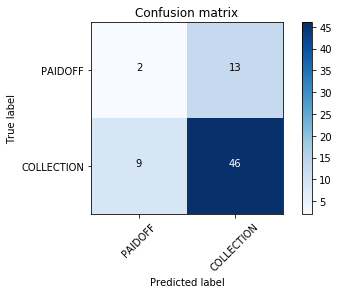

In [40]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [41]:
print (classification_report(y_test, yhat))

             precision    recall  f1-score   support

 COLLECTION       0.18      0.13      0.15        15
    PAIDOFF       0.78      0.84      0.81        55

avg / total       0.65      0.69      0.67        70



In [42]:
log_loss(y_test, yhat_prob)

0.57722876094796538

# Model Evaluation using Test set

First, download and load the test set:

In [43]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-02-27 14:50:02--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-02-27 14:50:02 (663 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [44]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>